Este notebook tiene el codigo de los dos algoritmos

# Estrategia General

1. Preprocesamiento de los nodos y aristas
2. Propagación de mensaje basado en algoritmo (Map) \\
    `[(node, property), ... ]`
3. Procesamiento de las respuestas (Reduce) \\
    `[(node, result), ... ]`
4. Actualización de las propiedades del algoritmo
5. Evaluación de condición de término del algoritmo


# Imports

In [ ]:
!pip install pyspark
!pip install pyvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=193891397ce06f64351ee185ca8e3f997f23835de321d02c227994c4068ad3c6
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.3 MB/s eta 0:00:00


In [ ]:
from pyspark.sql import Row
from pyspark.sql.functions import col, row_number, max
from pyspark.sql.window import Window

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pyvis.network import Network
import numpy as np
from random import randint

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .getOrCreate()

sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

# Create Random Graphs

In [ ]:
def buildAdjList(nodes, edges):
  g = {}
  for node in nodes:
    g[node] = []
  for edge in edges:
    g[edge[0]].append(edge[1])
  return g

In [ ]:
def plotGraph(G, node_size=50, arrow_size=15, line_thickness=0.2, names=False):
  # pos = nx.spring_layout(G)
  pos = nx.spring_layout(G, k=1, iterations=20)
  nx.draw_networkx_labels(G, pos, font_size=14, font_color='black')
  nx.draw_networkx_nodes(G, pos, node_size=node_size)
  nx.draw_networkx_edges(G, pos, width=line_thickness, arrowsize=arrow_size, node_size=node_size)
  plt.title('Grafo de Generado')
  plt.show()

In [ ]:
def createRandomGraph(n_nodes, prob_edge=0.5, directed=True, plot = True):
  G = nx.fast_gnp_random_graph(n_nodes, prob_edge, 42, True)
  if (plot):
    plotGraph(G, node_size=200)
  return G

In [ ]:
# Acá podria haber obtenido directamente la lista de adyacencia
# pero preferí obtener el input de datos descrito en el enunciado
def createRepresentation(G):
  edges = nx.to_edgelist(G)
  edges = [(i[0], i[1]) for i in edges]
  return list(G.nodes), edges

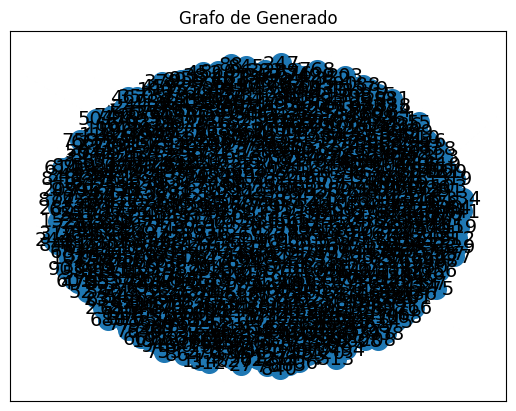

In [ ]:
G = createRandomGraph(1000, 0.4, False)

In [ ]:
nodes, edges = createRepresentation(G)

In [ ]:
print('Representacion definida en el doc')
print(f'nodes({len(nodes)}):  {nodes}\nedges ({len(edges)}): {edges}')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
adj = buildAdjList(nodes, edges)
print('Lista de adyacencia')
print(adj)

Lista de adyacencia
{0: [2, 3, 5, 6, 9, 10, 11, 12, 17, 18, 19, 20, 23, 24, 31, 39, 40, 41, 42, 43, 45, 47, 48, 49, 53, 54, 63, 64, 68, 72, 75, 79, 83, 90, 91, 94, 98, 99, 103, 107, 108, 110, 112, 114, 115, 118, 120, 121, 123, 124, 125, 130, 134, 137, 138, 140, 149, 152, 155, 156, 157, 159, 161, 162, 163, 164, 165, 167, 170, 171, 173, 174, 180, 182, 185, 187, 189, 191, 192, 194, 195, 197, 205, 206, 208, 211, 214, 215, 216, 219, 220, 221, 223, 224, 225, 227, 233, 235, 242, 243, 250, 251, 253, 254, 255, 259, 261, 263, 265, 268, 269, 271, 273, 277, 286, 288, 289, 290, 291, 293, 296, 302, 308, 312, 314, 315, 319, 321, 324, 328, 329, 334, 335, 336, 338, 339, 347, 348, 349, 350, 351, 358, 359, 360, 362, 371, 372, 373, 379, 382, 383, 384, 385, 386, 387, 389, 390, 391, 392, 393, 398, 401, 404, 407, 409, 413, 415, 418, 421, 422, 423, 425, 427, 430, 431, 433, 435, 436, 438, 441, 442, 444, 448, 450, 452, 454, 455, 456, 458, 462, 463, 466, 467, 476, 477, 479, 483, 488, 490, 494, 499, 502, 506, 507

# Page Rank

In [ ]:
def initRDDPageRank(nodes):
  n = len(nodes)
  data = [(node, 1/n) for node in nodes]
  return sc.parallelize(data)

In [ ]:
def propagatePageRank(node):
  propagation = []
  n_neigh = len(adj[node[0]])
  val_propagated = (node[1]/n_neigh) if n_neigh > 0 else 0
  for neigh in adj[node[0]]:
    propagation.append((neigh, val_propagated))
  return propagation

In [ ]:
def reducePropagation(rdd):
  flatten = rdd.flatMap(lambda x: x)
  return flatten.reduceByKey(lambda a,b: a+b)

In [ ]:
def applyDamping(node, dampling, dampling_factor):
  return (node[0], (node[1]*dampling)+dampling_factor)

In [ ]:
def pageRank(rdd, n_iter, dampling=0.85):
  dampling_factor = (1-dampling)/len(nodes) if len(nodes) > 0 else 0
  for _ in range(n_iter):
    propagated = rdd.map(propagatePageRank)
    reduced = reducePropagation(propagated)
    rdd = reduced.map(lambda node: applyDamping(node, dampling, dampling_factor))
    print(rdd.collect())
  return rdd

In [ ]:
rdd = initRDDPageRank(nodes)

In [ ]:
%%time
pr = pageRank(rdd, 10)

[(12, 0.0009594083056455869), (20, 0.0010092689202082243), (24, 0.0010476249570762987), (40, 0.000995562978128157), (48, 0.0010054442603060598), (64, 0.0010136407231980179), (68, 0.0010664004013855284), (72, 0.0010149817708038733), (108, 0.0009612866435685262), (112, 0.0009786482917677095), (120, 0.0010297245316635562), (124, 0.0010581369851687507), (140, 0.0010236552781513809), (152, 0.0010538525078649073), (156, 0.0010454576954613943), (164, 0.0010119824341561316), (180, 0.0009392124370323446), (192, 0.0009979253622007865), (208, 0.0010395564801698534), (216, 0.0010434349601663765), (220, 0.0009709492000326513), (224, 0.0009698387505207046), (268, 0.0009708240628622338), (288, 0.0009936118127945436), (296, 0.0009643073247431752), (308, 0.000977932737527887), (312, 0.0009615514597633996), (324, 0.0009907106630858916), (328, 0.0010389563184377837), (336, 0.0009756899472952733), (348, 0.001047354317140199), (360, 0.0010259974088274977), (372, 0.0009659290039154991), (384, 0.001000563637

In [ ]:
pr_results = pr.collect()
pr_results

In [ ]:
hash_results = {}
for node, pr_node in pr_results:
  hash_results[node] = pr_node
hash_results

In [ ]:
adj_pr = {}
for node, pr_node in pr_results:
  adj_pr[f'{node}\n{round(pr_node, 2)}'] = [ f'{n}\n{round(hash_results[n], 2)}' for n in adj[node]]
adj_pr

In [ ]:
graph_pr = nx.from_dict_of_lists(adj_pr)

In [ ]:
nodes_pr, edges_pr = createRepresentation(graph_pr)

In [ ]:
G_pr = nx.DiGraph()
G_pr.add_edges_from(edges_pr)
# plotGraph(G_pr, node_size=1200)

# Single Source Shortest Path

In [ ]:
edges_weighted = [(x, y, randint(1, 100) ) for x, y in edges ]

In [ ]:
G=nx.DiGraph()
for x,y,w in edges_weighted:
  G.add_edge(x,y,weight=w)

# node_size = 1000
# line_thickness = 0.2
# arrow_size=15
# labels = nx.get_edge_attributes(G,'weight')
# pos = nx.spring_layout(G, k=1, iterations=20)
# nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)
# nx.draw_networkx_labels(G, pos, font_size=14, font_color='black')
# nx.draw_networkx_nodes(G, pos, node_size=node_size)
# nx.draw_networkx_edges(G, pos, width=line_thickness, arrowsize=arrow_size, node_size=node_size)
# plt.title('Grafo de Generado')
# plt.show()

In [ ]:
weights = np.zeros((len(nodes), len(nodes)))
for x, y, w in edges_weighted:
  weights[x][y] = w
weights

array([[ 0.,  0., 23., ..., 27.,  0., 38.],
       [25.,  0., 33., ...,  0., 13.,  7.],
       [ 6., 63.,  0., ..., 36.,  0.,  0.],
       ...,
       [13., 86.,  0., ...,  0., 83.,  0.],
       [81., 45.,  7., ..., 95.,  0., 35.],
       [57.,  0.,  0., ...,  0.,  0.,  0.]])

In [ ]:
def sendWeights(neighbors, init, weights, currentWeights):
  neighbors_weights = neighbors.map(lambda neigh: (neigh, weights[init][neigh] + currentWeights[init]))
  neighbors_weights = neighbors_weights.filter(lambda weight: weight[1] < currentWeights[weight[0]])
  return neighbors_weights

In [ ]:
def dijkstraSpark(init, nodes, weights):
  neighbors_rdds = {}
  adj_w = buildAdjList(nodes, edges)
  for node in nodes:
    neighbors_rdds[node] = sc.parallelize(adj_w[node])

  init_node = [init]
  queue = [init_node]
  currentWeights = { i: 0 if i in init_node else np.inf for i in nodes }

  while len(queue) > 0:
    current = queue.pop(0)
    weights_res = sc.parallelize([sendWeights(neighbors_rdds[n], n, weights, currentWeights).collect() for n in current])
    weights_res = weights_res.flatMap(lambda x: x)
    weights_res = weights_res.groupByKey().mapValues(list)
    weights_res = weights_res.mapValues(lambda weight: min(weight))
    new_weights = weights_res.collect()

    next = []
    for node, weight in new_weights:
      currentWeights[node] = weight
      next.append(node)
    if len(next) > 0:
      queue.append(next)

  return currentWeights

In [ ]:
%%time
res = dijkstraSpark(0, nodes, weights)

CPU times: user 42.5 s, sys: 30.6 s, total: 1min 13s
Wall time: 14min 54s


In [ ]:
res